## RQ2. How frequent are, and what are the main characteristics of long-lived bugs in FLOSS projects?

## Experimental parameters


| Parameter                  |         Value        |
|----------------------------|:--------------------:|
| OSS Project                |        Eclipse       |
| Number of Bug Reports      |        8438          |
| Threshold (in days)        |          365         |

Every bug which its report have indicated that the number of days to resolve is less than or equal to **threshold fixed** was considered a **non-long lived bug** and that which the number of days to resolve is greater than this threshold was considered as a **long-live bug**. 

## Step1. Setup experimental environment.

In [34]:
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline 
plt.style.use('default')
plt.rc('figure', figsize=(10, 10))

import seaborn as sns 
sns.set_context("paper")

import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Path of the file to read.
bug_reports_path = 'datasets/20190824_eclipse_bug_report_data.csv'
bug_reports_history_path = 'datasets/20190824_eclipse_bug_report_history_data.csv'

# Fixed time threshold.
bug_fix_time_threshold = 365
print("Setup complete")

Setup complete


## Step 2. Load data.

In [35]:

!echo "Header of bug reports file"
!head -n 2 $bug_reports_path

!echo "\nNumber of lines in the file:"
!wc -l $bug_reports_path


Header of bug reports file
bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code
EMF-354412,2011-08-10,cdo.core,EMF,containsAll returns wrong result in case of detached objects,"Cloned from: 354395: containsAll returns wrong result in case of detached objects

Number of lines in the file:
339097 datasets/20190824_eclipse_bug_report_data.csv


In [36]:
bug_reports_data = pd.read_csv(bug_reports_path)
rows_and_cols = bug_reports_data.shape
print('There are {} rows and {} columns.\n'.format(
        rows_and_cols[0], rows_and_cols[1]
    )
)

print(bug_reports_data.info())

There are 21391 rows and 19 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21391 entries, 0 to 21390
Data columns (total 19 columns):
bug_id                  21391 non-null object
creation_date           21391 non-null object
component_name          21391 non-null object
product_name            21391 non-null object
short_description       21390 non-null object
long_description        21084 non-null object
assignee_name           21391 non-null object
reporter_name           21391 non-null object
resolution_category     21391 non-null object
resolution_code         21391 non-null int64
status_category         21391 non-null object
status_code             21391 non-null int64
update_date             21391 non-null object
quantity_of_votes       21391 non-null int64
quantity_of_comments    21391 non-null int64
resolution_date         21391 non-null object
bug_fix_time            21391 non-null int64
severity_category       21391 non-null object
severity_code           21391 

In [37]:
!echo "Header of bug reports history file"
!head -n 2 $bug_reports_history_path

!echo "\nNumber of lines in the history file:"
!wc -l $bug_reports_history_path


Header of bug reports history file
Key,Who,When,What,Removed,Added
EMF-354412,stepper,2011-08-10,status,new,assigned

Number of lines in the history file:
168721 datasets/20190824_eclipse_bug_report_history_data.csv


In [38]:
bug_reports_history_data = pd.read_csv(bug_reports_history_path, sep=',')
rows_and_cols = bug_reports_history_data.shape
print('There are {} rows and {} columns.\n'.format(
        rows_and_cols[0], rows_and_cols[1]
    )
)

print(bug_reports_history_data.info())

There are 168720 rows and 6 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168720 entries, 0 to 168719
Data columns (total 6 columns):
Key        168720 non-null object
Who        168720 non-null object
When       168720 non-null object
What       168720 non-null object
Removed    128344 non-null object
Added      167259 non-null object
dtypes: object(6)
memory usage: 7.7+ MB
None


## Step 3. Review the data

In [39]:
bug_reports_history_data.head()

,Key,Who,When,What,Removed,Added
0,EMF-354412,stepper,2011-08-10,status,new,assigned
1,EMF-354412,stepper,2011-08-10,assignee,emf.cdo-inbox,stepper
2,EMF-354412,stepper,2011-08-10,status,assigned,resolved
3,EMF-354412,stepper,2011-08-10,resolution,---,fixed
4,EMF-354412,stepper,2012-09-21,status,resolved,closed


## Step 4. Pre-processing the data

In [40]:
bug_reports_data['resolution_code'] = bug_reports_data['resolution_code'].astype('category')
bug_reports_data['status_category'] = bug_reports_data['status_category'].astype('category')
bug_reports_data['severity_code']   = bug_reports_data['severity_code'].astype('category')
bug_reports_data['short_description_length'] = bug_reports_data['short_description'].str.len()
bug_reports_data['long_description_length']  = bug_reports_data['long_description'].str.len()
bug_reports_data['short_description_length'] = bug_reports_data['short_description_length'].fillna(0)
bug_reports_data['long_description_length'] = bug_reports_data['long_description_length']
bug_reports_data['long_lived?']  = bug_reports_data['bug_fix_time'].apply(lambda t: 'long-lived' if t > 365 else 'short-lived')
bug_reports_data['long_lived?']  = bug_reports_data['long_lived?'].astype('category')
bug_reports_data.head()

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,...,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,short_description_length,long_description_length,long_lived?
0,EMF-354412,2011-08-10,cdo.core,EMF,containsAll returns wrong result in case of de...,Cloned from: 354395: containsAll returns wrong...,stepper,stepper,fixed,1,...,2012-09-21,0,5,2011-08-10,0,normal,2,60.0,911.0,short-lived
1,JSDT-253166,2008-11-03,General,JSDT,Javascript validation has several errors with ...,Some of our javascript-files yield parse-error...,cmjaun,acm,fixed,1,...,2010-03-03,0,6,2009-04-29,177,normal,2,58.0,1141.0,short-lived
2,ECLIPSELINK-338573,2011-03-01,SDO,ECLIPSELINK,Memory Improvement: Reduce the instances of S...,Currently the SDO/OXM metadata is referring to...,blaise.doughan,blaise.doughan,fixed,1,...,2011-03-02,0,5,2011-03-02,1,normal,2,51.0,140.0,short-lived
3,BIRT-150200,2006-07-10,Chart,BIRT,Stacked Area Chart: fill.set() ignored in befo...,In the attached report the fill.set() is being...,nli,eclipse,fixed,1,...,2010-03-24,0,7,2006-08-29,50,major,4,63.0,193.0,short-lived
4,PAPYRUS-384964,2012-07-12,Core,PAPYRUS,[StateMachine Diagram] Papyrus does not forbid...,In some situation (seem to be when an element ...,ansgar.radermacher,yann.tanguy,fixed,1,...,2013-04-02,0,3,2013-04-02,264,critical,5,92.0,557.0,short-lived


## Step 5. How frequent are long-lived bugs?

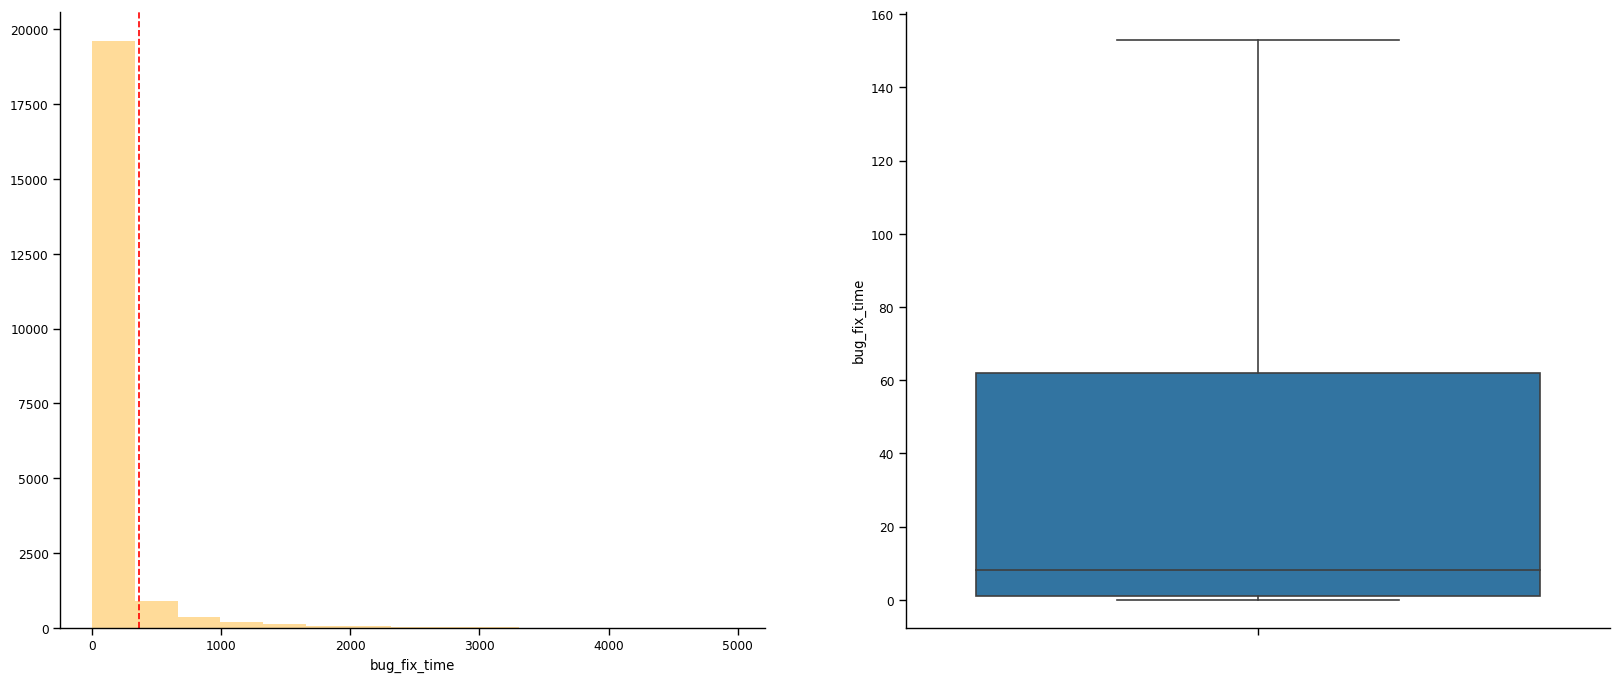

In [41]:
fig, ax = plt.subplots(figsize=(20,8), ncols=2)
sns.despine()
g = sns.distplot(bug_reports_data['bug_fix_time'], kde=False, bins=15, hist=True, color="orange", ax=ax[0])
g.axvline(bug_fix_time_threshold, color='r', linestyle='--', label = "Threshold : {}".format(bug_fix_time_threshold))
g = sns.boxplot(y="bug_fix_time", data=bug_reports_data, showfliers=False, ax=ax[1])

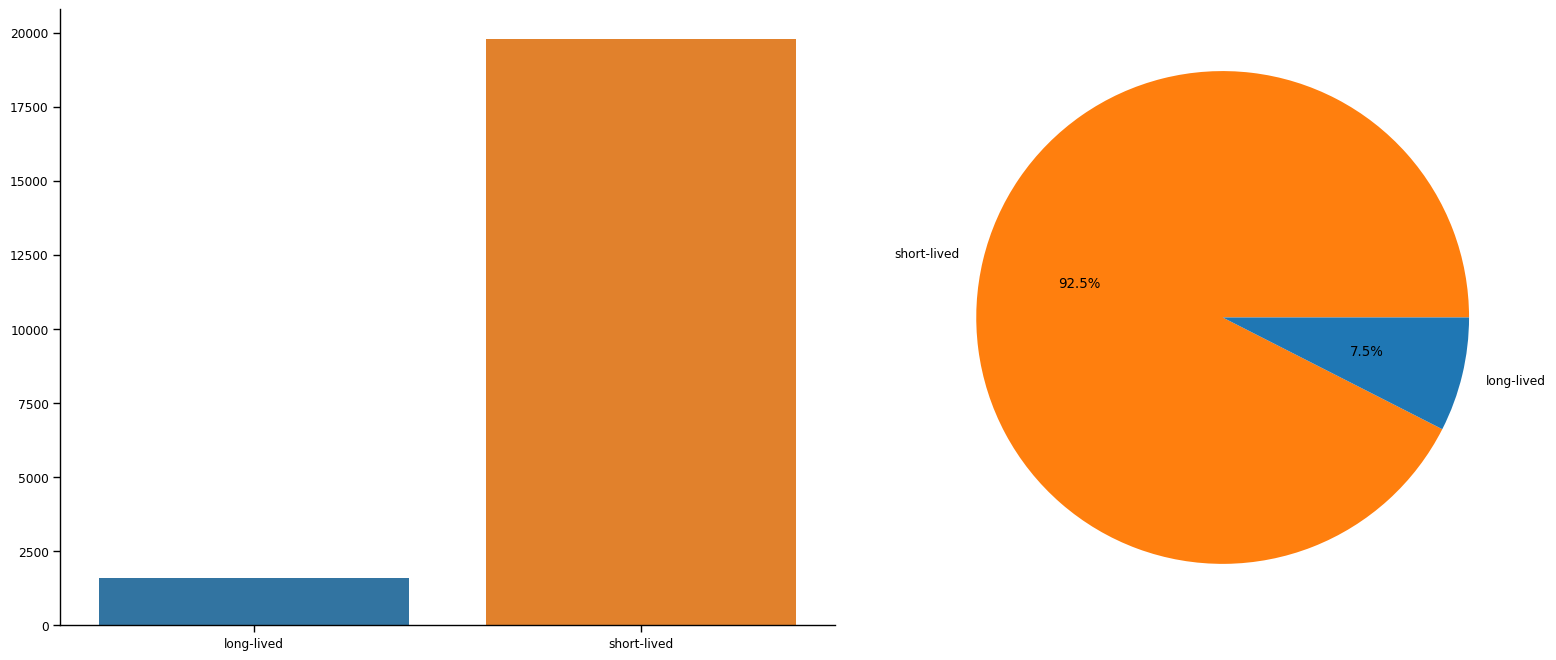

In [42]:
bug_reports_count = bug_reports_data["long_lived?"].value_counts()

f, axes = plt.subplots(figsize=(20,8), ncols=2)
sns.despine()

sns.barplot(x=bug_reports_count.index, y=bug_reports_count.values, palette=[ "tab:blue", "tab:orange"], ax=axes[0])
axes[1].pie(bug_reports_count.values, labels=bug_reports_count.index, autopct='%1.1f%%', colors=["tab:orange", "tab:blue"])

plt.subplots_adjust(wspace=0, hspace=1)

## Step 6. How is the distribution of severity level?

[Text(0, 0.5, 'Percentage'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Distribution of severity level')]

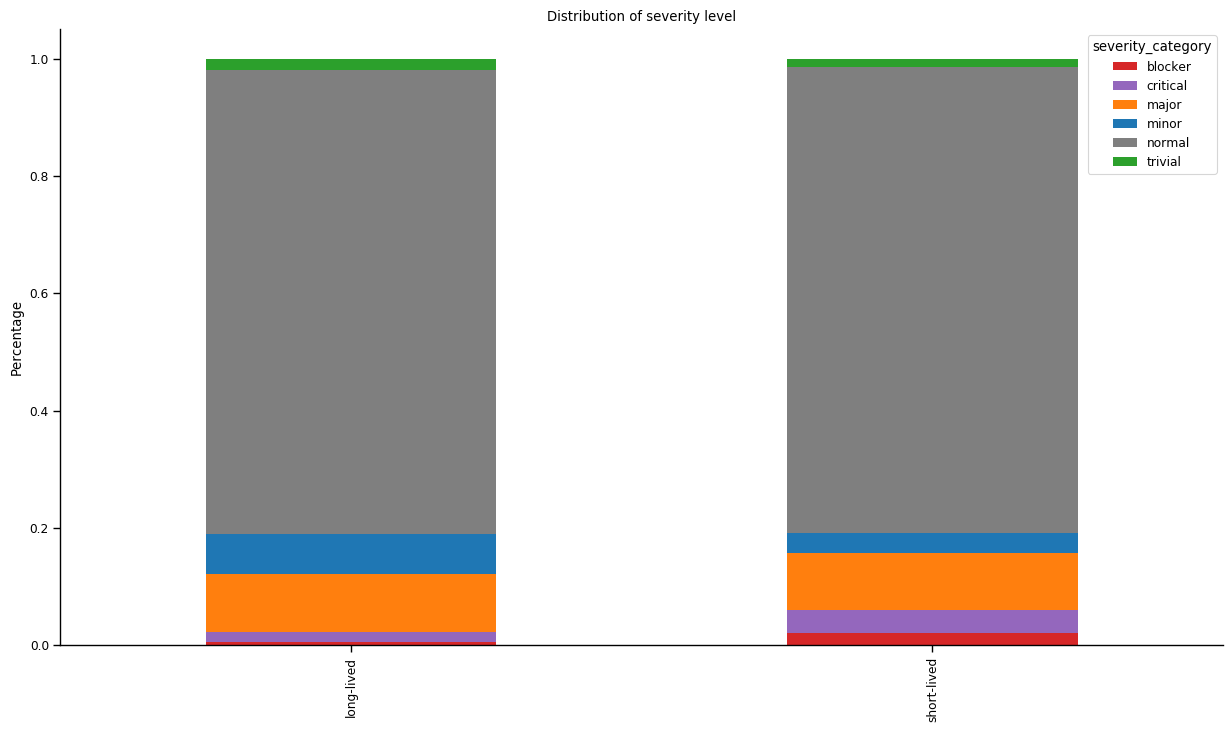

In [43]:
fig, axes = plt.subplots(figsize=(15,8))
sns.despine()
severity_palette=color=["tab:red", "tab:purple", "tab:orange", "tab:blue", "tab:gray", "tab:green"]
bug_reports_data_grouped = bug_reports_data.groupby("long_lived?")['severity_category'].value_counts(normalize=True).unstack()
bug_reports_data_grouped.plot(kind='bar', stacked='True', color=severity_palette, ax=axes)

axes.set(title="Distribution of severity level", xlabel="", ylabel="Percentage")


[Text(0.5, 0, ''), Text(0.5, 1.0, 'short-lived')]

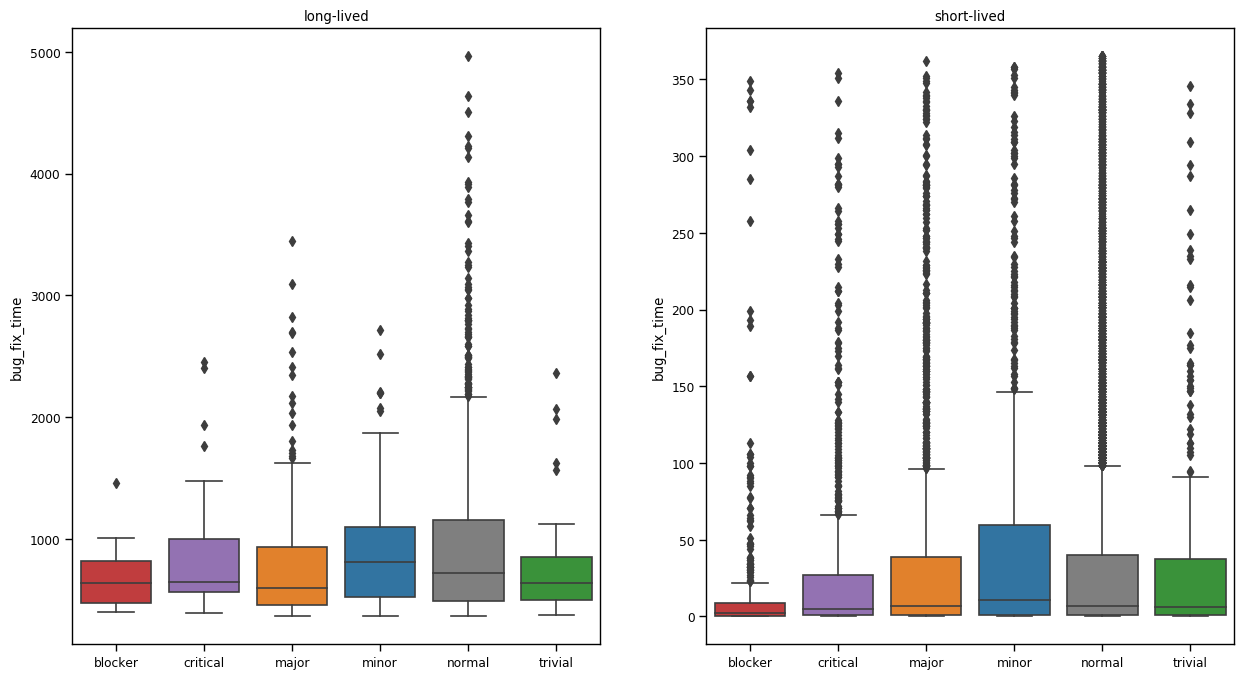

In [44]:
fig, ax = plt.subplots(figsize=(15,8), ncols=2)

g1 = sns.boxplot(data=bug_reports_data[bug_reports_data['long_lived?']=='long-lived']
                 , x="severity_category", y="bug_fix_time"
                , order=['blocker', 'critical', 'major', 'minor', 'normal', 'trivial']
                , palette=severity_palette
                , showfliers=True
                , ax=ax[0])
g1.set(title="long-lived", xlabel="")

g2 = sns.boxplot(data=bug_reports_data[bug_reports_data['long_lived?']=='short-lived']
                 , x="severity_category", y="bug_fix_time"
                , order=['blocker', 'critical', 'major', 'minor', 'normal', 'trivial']
                , palette=severity_palette
                , showfliers=True
                , ax=ax[1])
g2.set(title="short-lived", xlabel="")


## Step 7. How is the distribution of number of chracters in short and long description?

[Text(0, 0.5, 'Number of characters'),
 Text(0.5, 0, ' '),
 Text(0.5, 1.0, 'Distribution of number of characters in short description')]

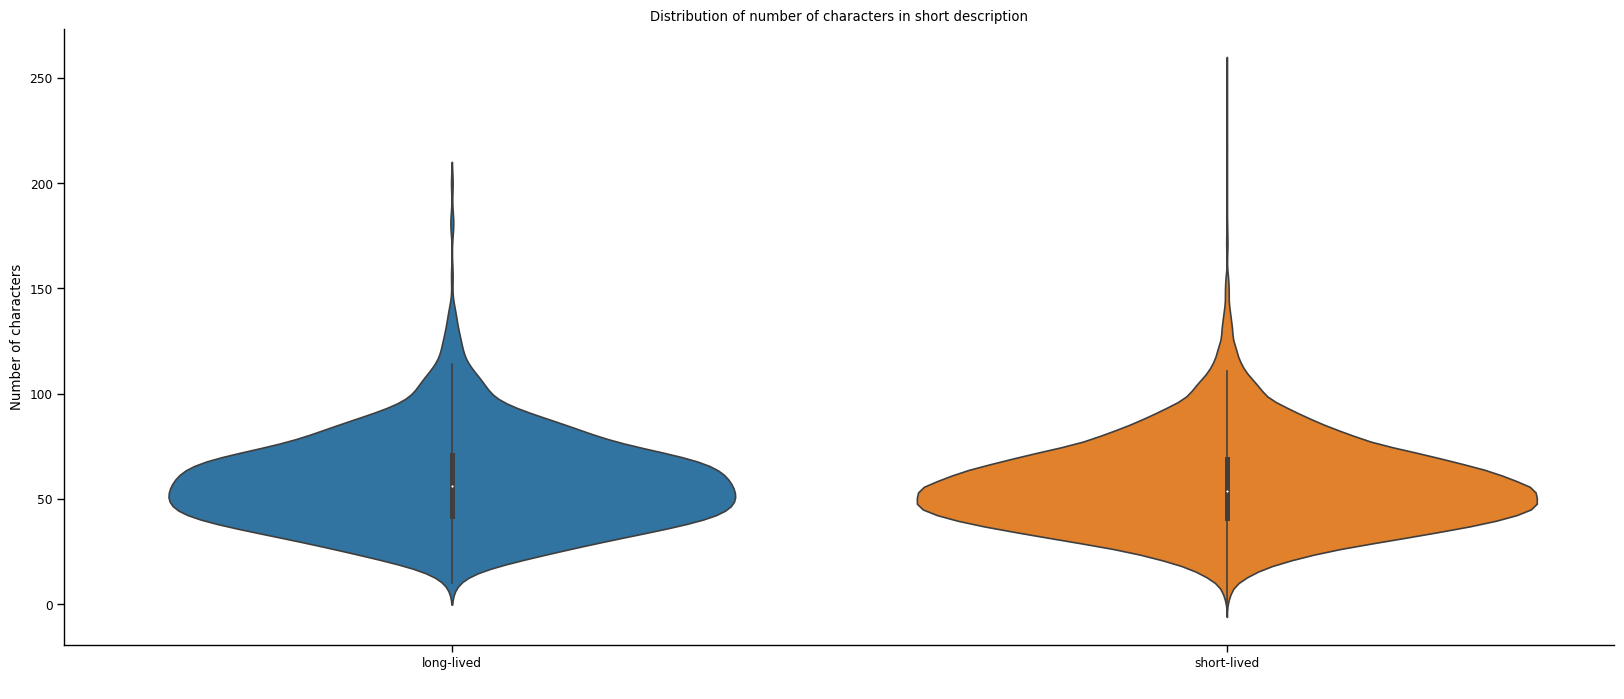

In [45]:
fig, ax = plt.subplots(figsize=(20,8), ncols=1)
sns.despine()

g = sns.violinplot(x="long_lived?", y="short_description_length", data=bug_reports_data)
g.set(title="Distribution of number of characters in short description", ylabel="Number of characters", xlabel=" ")

[None]

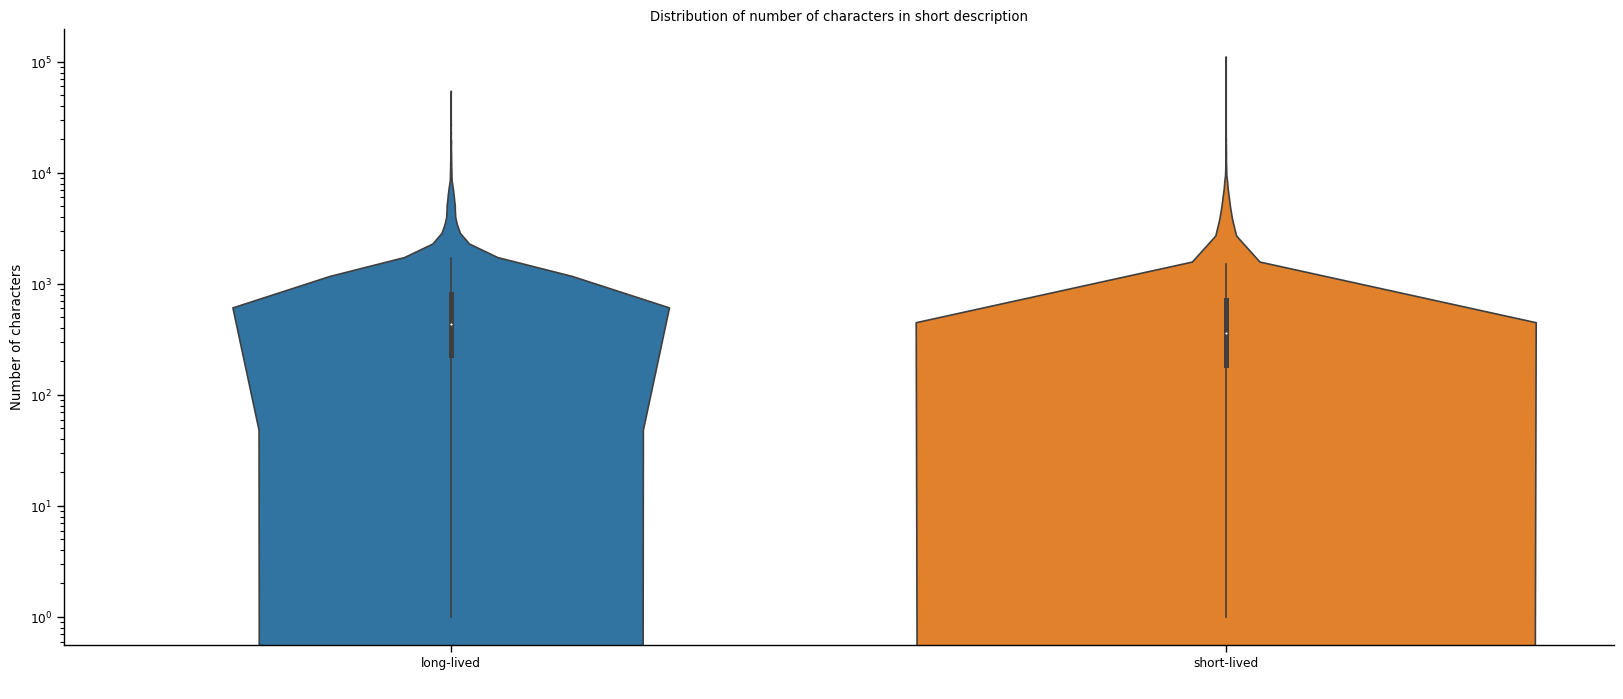

In [46]:
fig, ax = plt.subplots(figsize=(20,8), ncols=1)
sns.despine()

g = sns.violinplot(x="long_lived?", y="long_description_length", data=bug_reports_data)
g.set(title="Distribution of number of characters in short description", ylabel="Number of characters", xlabel=" ")
g.set(yscale="log")

### Step 8. Bug Reporter

In [47]:
number_of_reports   = bug_reports_data['bug_id'].count()
number_of_reporters = bug_reports_data['reporter_name'].nunique()
print("%s reporters reported %s bugs." % (number_of_reporters, number_of_reports))

4614 reporters reported 21391 bugs.


In [48]:
top_10_reporters = bug_reports_data.groupby('reporter_name').reporter_name.agg(['count'])
top_10_reporters = top_10_reporters.sort_values('count', ascending=False)[0:10]
top_10_reporters

,count
reporter_name,
david_williams,278
eclipse,226
markus.kell.r,193
wayne.beaton,193
john.arthorne,174
Lars.Vogel,150
ed,146
pascal,144
daniel_megert,141


[Text(0, 0.5, 'Bug fix time'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Bug fix time by components')]

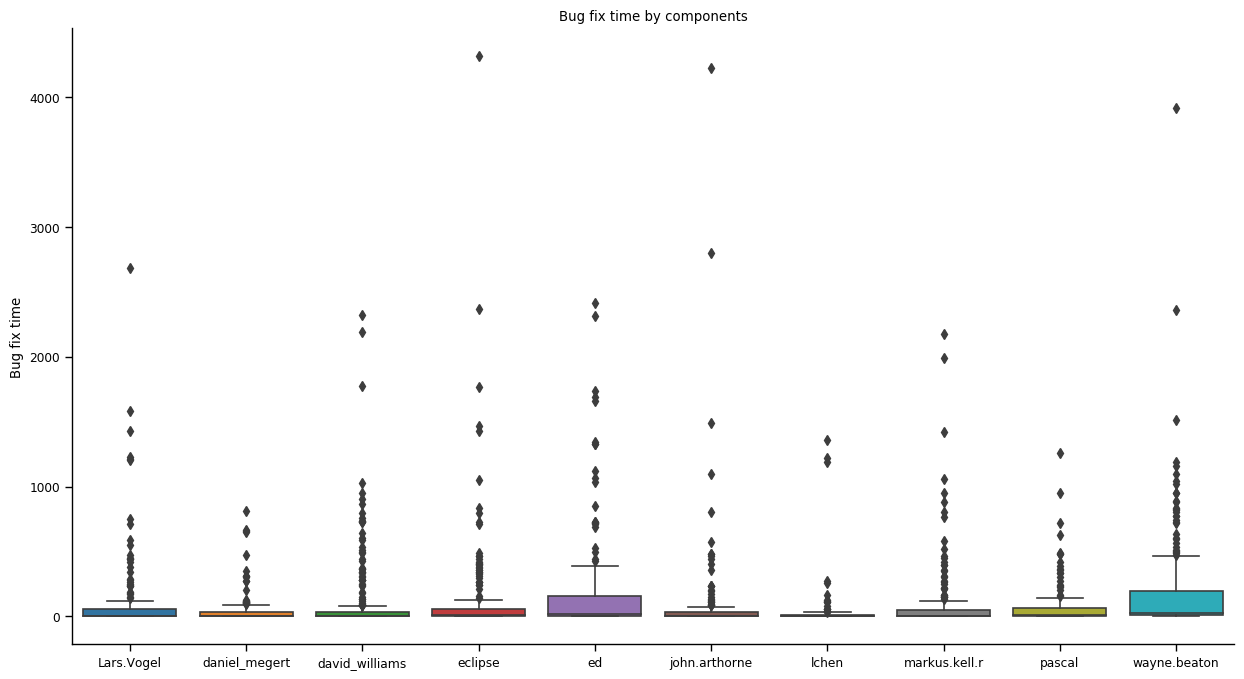

In [49]:
fig, ax = plt.subplots(figsize=(15,8))
sns.despine()
bug_reports_data_for_top_10_reporters=bug_reports_data[bug_reports_data['reporter_name'].isin(top_10_reporters.index)]
bug_reports_data_for_top_10_reporters=bug_reports_data_for_top_10_reporters.sort_values(by=['reporter_name'])
g = sns.boxplot(data=bug_reports_data_for_top_10_reporters
            , x="reporter_name"
            , y="bug_fix_time"
            , showfliers=True)
g.set(title="Bug fix time by components", xlabel="", ylabel="Bug fix time")

[Text(0, 0.5, 'Percentage'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Bug reports by reporter')]

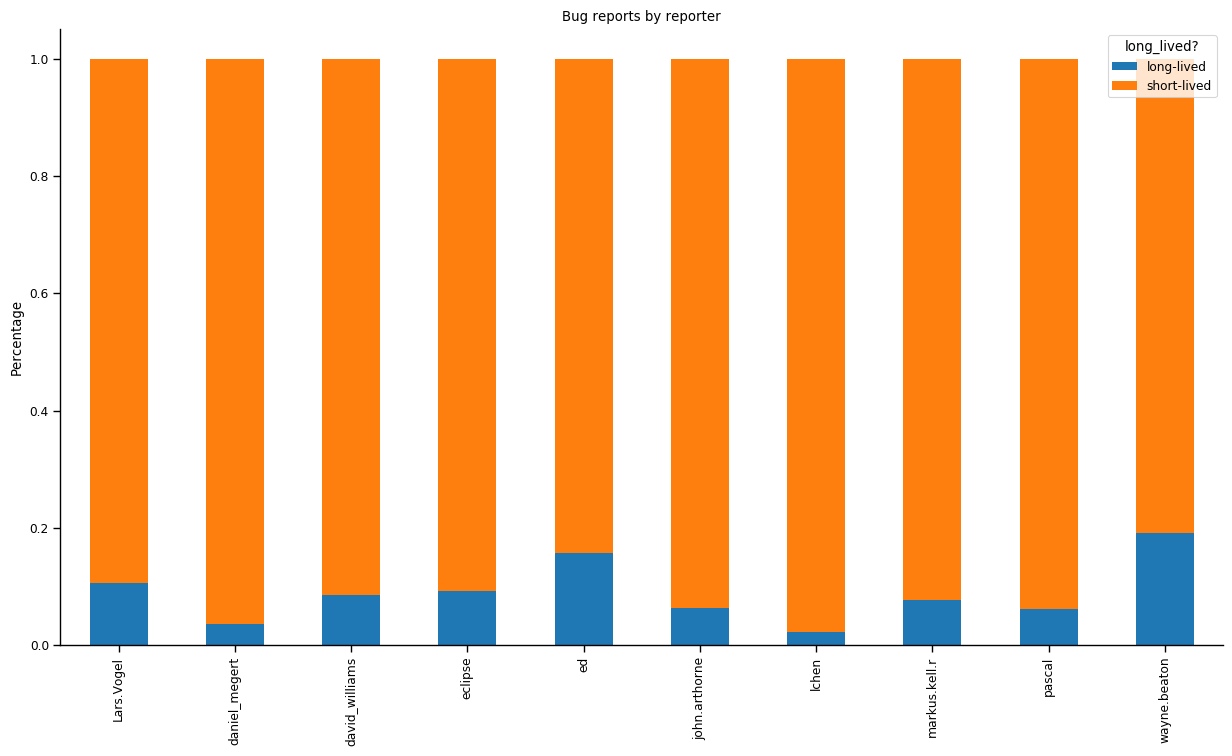

In [50]:
fig, axes = plt.subplots(figsize=(15,8))
sns.despine()
palette=color=["tab:blue", "tab:orange"]
bug_reports_data_grouped = bug_reports_data_for_top_10_reporters.groupby("reporter_name")['long_lived?'].value_counts(normalize=True).unstack()
bug_reports_data_grouped.plot(kind='bar', stacked='True', color=palette, ax=axes)

axes.set(title="Bug reports by reporter", xlabel="", ylabel="Percentage")


## Step 9. Assignee

In [51]:
top_10_assignee = bug_reports_data.groupby('assignee_name').assignee_name.agg(['count'])
top_10_assignee = top_10_assignee.sort_values('count', ascending=False)[0:9]
top_10_assignee

,count
assignee_name,
webmaster,468
rap-inbox,243
tmf.xtext-inbox,230
Silenio_Quarti,196
emo,174
eclipse,166
mdt-papyrus-inbox,164
david_williams,157
pde-ui-inbox,154


[Text(0, 0.5, 'Bug fix time'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Bug fix time by assignee')]

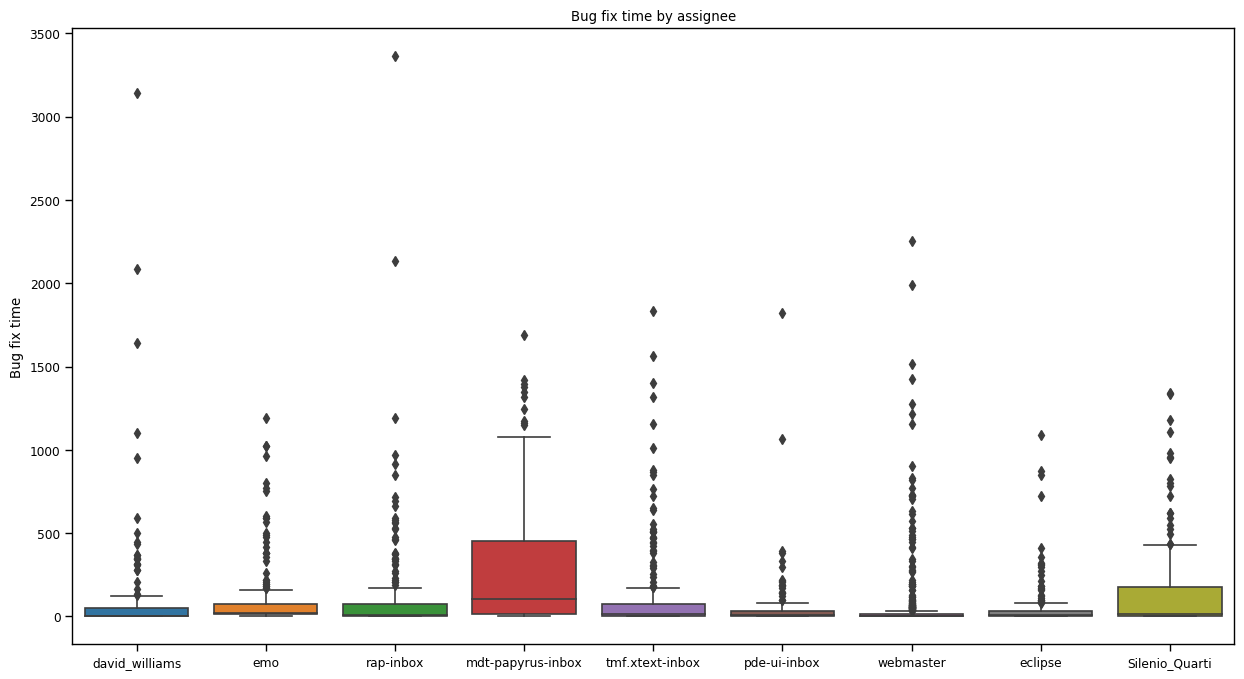

In [52]:
fig, ax = plt.subplots(figsize=(15,8))
bug_reports_data_for_top_10_assignee=bug_reports_data[bug_reports_data['assignee_name'].isin(top_10_assignee.index)] 
g = sns.boxplot(data=bug_reports_data_for_top_10_assignee
            , x="assignee_name"
            , y="bug_fix_time"
            , showfliers=True)
g.set(title="Bug fix time by assignee", xlabel="", ylabel="Bug fix time")

[Text(0, 0.5, 'Percentage'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Bug reports by assignee')]

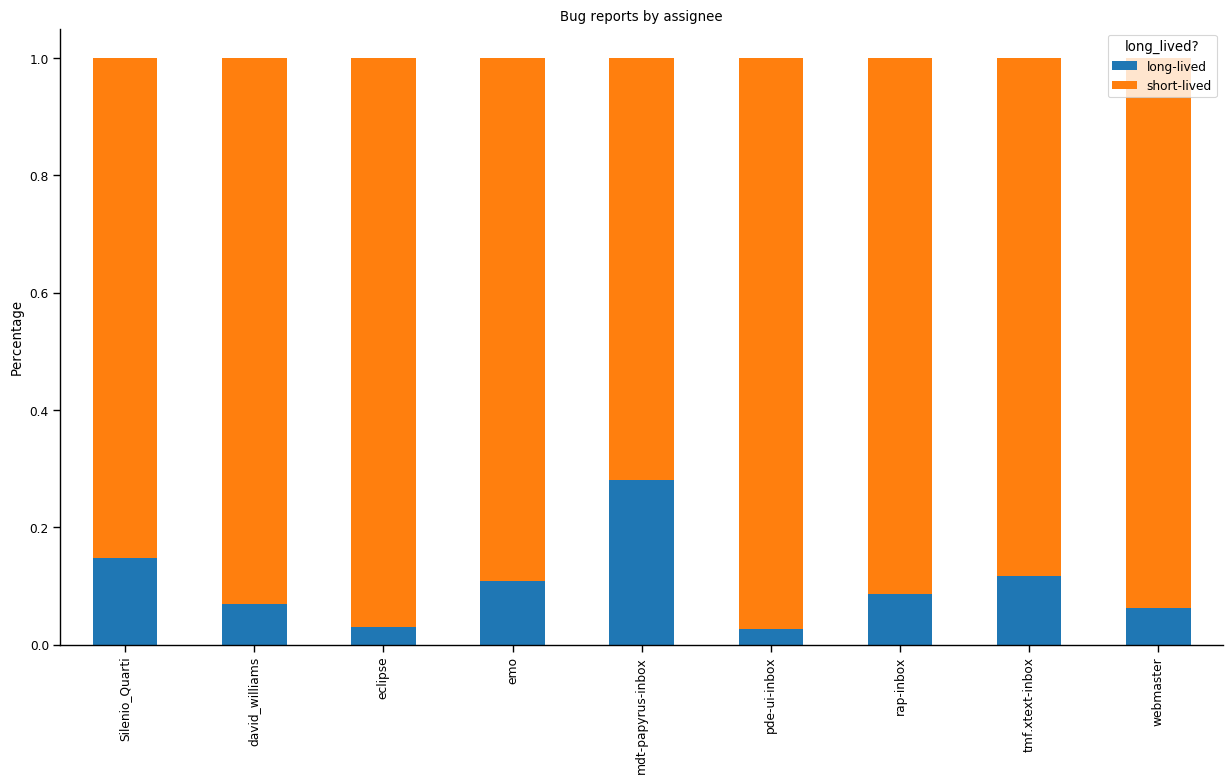

In [53]:
fig, axes = plt.subplots(figsize=(15,8))
sns.despine()
palette=color=["tab:blue", "tab:orange"]
bug_reports_data_grouped = bug_reports_data_for_top_10_assignee.groupby("assignee_name")['long_lived?'].value_counts(normalize=True).unstack()
bug_reports_data_grouped.plot(kind='bar', stacked='True', color=palette, ax=axes)

axes.set(title="Bug reports by assignee", xlabel="", ylabel="Percentage")

## Step 10. Component

In [54]:
top_10_component = bug_reports_data.groupby('component_name').component_name.agg(['count'])
top_10_component = top_10_component.sort_values('count', ascending=False)[0:10]
top_10_component

,count
component_name,
UI,2346
Core,1697
SWT,783
TPTP,613
General,430
Releng,405
Client,345
cdt-core,287
Xtext,268


[Text(0, 0.5, 'Bug fix time'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Bug fix time by components')]

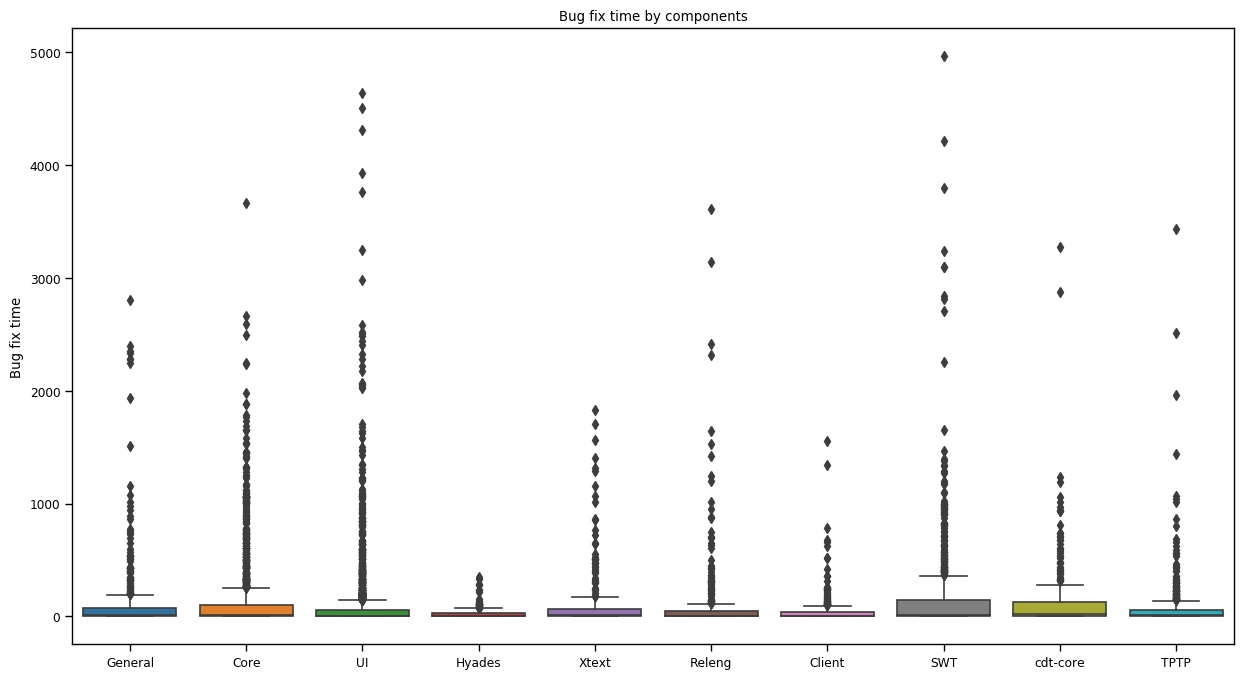

In [55]:
fig, ax = plt.subplots(figsize=(15,8))
bug_reports_data_for_top_10_component=bug_reports_data[bug_reports_data['component_name'].isin(top_10_component.index)] 
g = sns.boxplot(data=bug_reports_data_for_top_10_component
            , x="component_name"
            , y="bug_fix_time"
            , showfliers=True)
g.set(title="Bug fix time by components", xlabel="", ylabel="Bug fix time")

[Text(0, 0.5, 'Percentage'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Bug reports by components')]

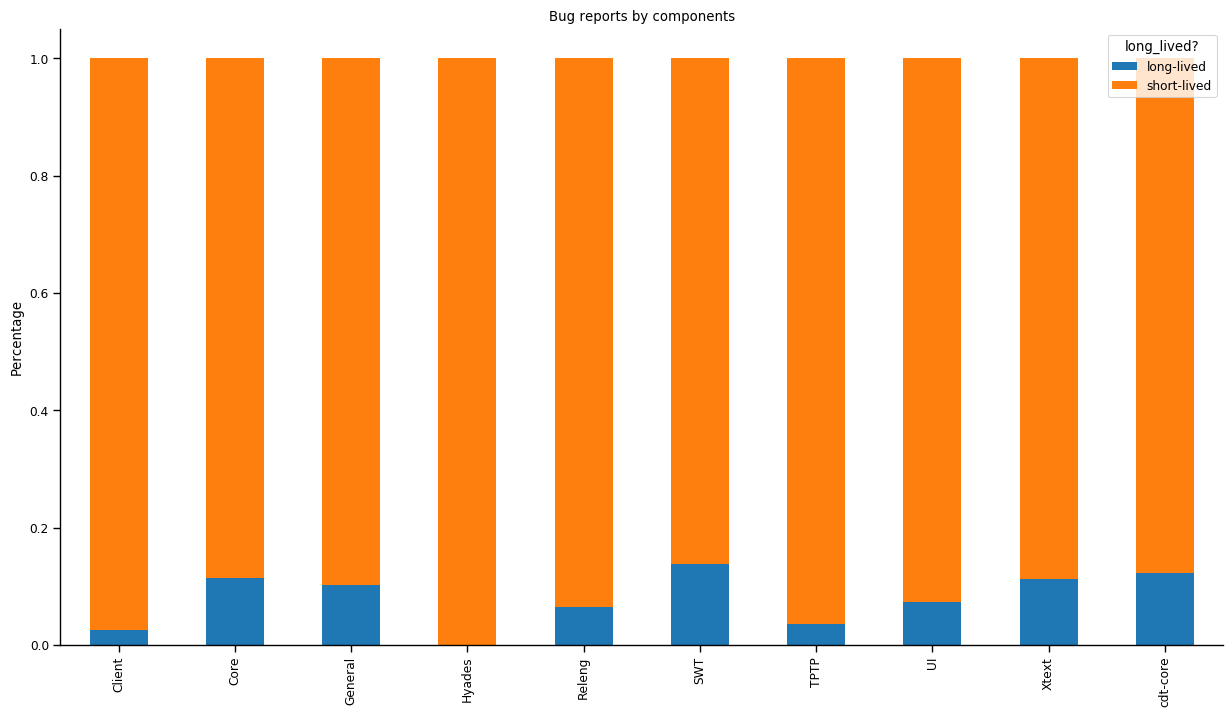

In [56]:
fig, axes = plt.subplots(figsize=(15,8))
sns.despine()
palette=color=["tab:blue", "tab:orange"]
bug_reports_data_grouped = bug_reports_data_for_top_10_component.groupby("component_name")['long_lived?'].value_counts(normalize=True).unstack()
bug_reports_data_grouped.plot(kind='bar', stacked='True', color=palette, ax=axes)

axes.set(title="Bug reports by components", xlabel="", ylabel="Percentage")